# 1장 - 심층 합성곱 신경망으로 이미지 분류 (part 2)

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

from IPython.display import Image

import matplotlib.pyplot as plt


# 합성곱 신경망을 사용하여 얼굴 이미지의 성별 분류

이 절에서 CNN으로 CelebA 데이터셋에 있는 얼굴 이미지의 성별을 분류해 보자.  

지금까지 배운 것을 토대로 이 절에서 얼굴 이미지의 성별을 예측하는 CNN 모델을 만들어 본다. 난이도를 줄이기 위해 훈련 데이터의 일부(1만 6,000개의 훈련 샘플)만 사용하여 훈련 과정의 속도를 높인다. 하지만 일반화 성능을 높이고 작은 데이터셋에서 과대적합을 막기 위해 **데이터 증식**(data augmentation)기법을 사용.

## CelebA 데이터셋 로드

In [3]:
celeba_bldr = tfds.builder('celeb_a')
celeba_bldr.download_and_prepare()
celeba = celeba_bldr.as_dataset(shuffle_files=False)
print(celeba.keys())

celeba_train = celeba['train']
celeba_valid = celeba['validation']
celeba_test = celeba['test']

def count_items(ds):
    n = 0
    for _ in ds:
        n += 1
    return n

print('훈련 데이터셋:  {}'.format(count_items(celeba_train)))
print('검증 데이터셋:  {}'.format(count_items(celeba_valid)))
print('테스트 데이터셋: {}'.format(count_items(celeba_test)))

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-24 14:02:37.993823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-24 14:02:37.993958: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


dict_keys(['train', 'validation', 'test'])


2022-11-24 14:02:38.280412: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-24 14:02:38.280602: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


훈련 데이터셋:  162770
검증 데이터셋:  19867
테스트 데이터셋: 19962


In [4]:
celeba_train = celeba_train.take(16000)
celeba_valid = celeba_valid.take(1000)

print('훈련 데이터셋: {}'.format(count_items(celeba_train)))
print('검증 데이터셋: {}'.format(count_items(celeba_valid)))

훈련 데이터셋: 16000
검증 데이터셋: 1000


## 이미지 변환과 데이터 증식

데이터 증식은 부족한 훈련 데이터를 해결하기 위해 적용할 수 있는 다양한 기술의 집합이다. 예를 들어 어떤 데이터 증식 기법은 데이터를 수정하거나 심지어 더 많은 데이터를 인공적으로 합성할 수도 있다. 따라서 과대적합을 줄이고 머신 러닝과 딥러닝 모델의 성능을 높일 수 있다.  
데이터 증식이 이미지 데이터에만 적용되는 것은 아니지만 이미지 데이터에만 적용할 수 있는 변환 기법들이 있다. 예를 들어 이미지를 잘라 내거나 뒤집거나 대비, 명도, 채도를 바꿀 수 있다. `tf.image` 모듈에서 제공되는 이런 변환 기법을 살펴보자.

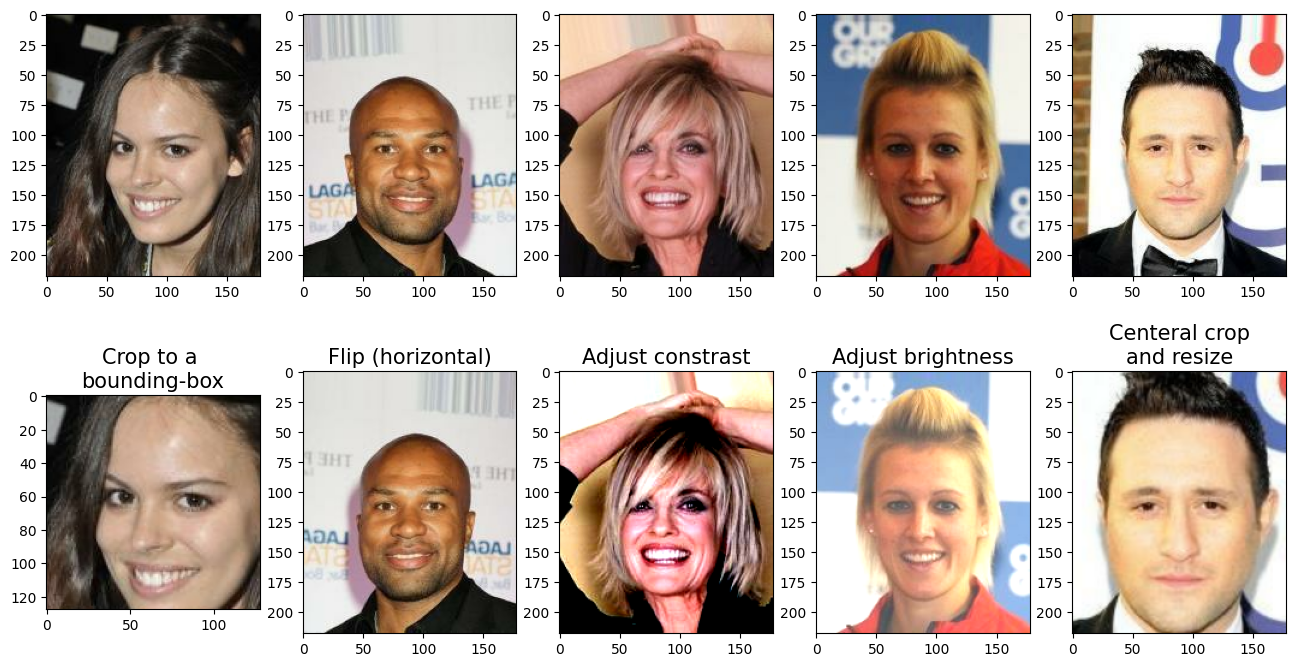

In [5]:
## 5개 샘플을 가져옵니다
examples = []
for example in celeba_train.take(5):
    examples.append(example['image'])

fig = plt.figure(figsize=(16, 8.5))

## 1열: 바운딩 박스로 자르기
ax = fig.add_subplot(2, 5, 1)
ax.imshow(examples[0])
ax = fig.add_subplot(2, 5, 6)
ax.set_title('Crop to a \nbounding-box', size=15)
img_cropped = tf.image.crop_to_bounding_box(
    examples[0], 50, 20, 128, 128)
ax.imshow(img_cropped)

## 2열: (수평으로) 뒤집기
ax = fig.add_subplot(2, 5, 2)
ax.imshow(examples[1])
ax = fig.add_subplot(2, 5, 7)
ax.set_title('Flip (horizontal)', size=15)
img_flipped = tf.image.flip_left_right(examples[1])
ax.imshow(img_flipped)

## 3열: 대비 조정
ax = fig.add_subplot(2, 5, 3)
ax.imshow(examples[2])
ax = fig.add_subplot(2, 5, 8)
ax.set_title('Adjust constrast', size=15)
img_adj_contrast = tf.image.adjust_contrast(
    examples[2], contrast_factor=2)
ax.imshow(img_adj_contrast)

## 4열: 명도 조정
ax = fig.add_subplot(2, 5, 4)
ax.imshow(examples[3])
ax = fig.add_subplot(2, 5, 9)
ax.set_title('Adjust brightness', size=15)
img_adj_brightness = tf.image.adjust_brightness(
    examples[3], delta=0.3)
ax.imshow(img_adj_brightness)

## 5열: 이미지 중앙 자르기
ax = fig.add_subplot(2, 5, 5)
ax.imshow(examples[4])
ax = fig.add_subplot(2, 5, 10)
ax.set_title('Centeral crop\nand resize', size=15)
img_center_crop = tf.image.central_crop(
    examples[4], 0.7)
img_resized = tf.image.resize(
    img_center_crop, size=(218, 178))
ax.imshow(img_resized.numpy().astype('uint8'))

# plt.savefig('images/15_14.png', dpi=300)
plt.show()

코드에 있는 변환은 결정적이다. 하지만 이런 변환은 모두 랜덤하게 수행할 수 있으며 모델 훈련을 위한 데이터 증식에 권장되는 방식이다. 예를 들어 이미지에서 랜덤한 바운딩 박스를 잘라 낼 수 있다. 이미지를 절반의 확률로 수평 또는 수직으로 랜덤하게 뒤집을 수 있다. 또는 `contrast_factor`를 랜덤하게 선택하여 이미지 대비를 특정 범위를 가진 균등 분포에서 랜덤하게 바꿀 수 있다. 이런 변환을 파이프라인으로 연결할 수도 있다.  

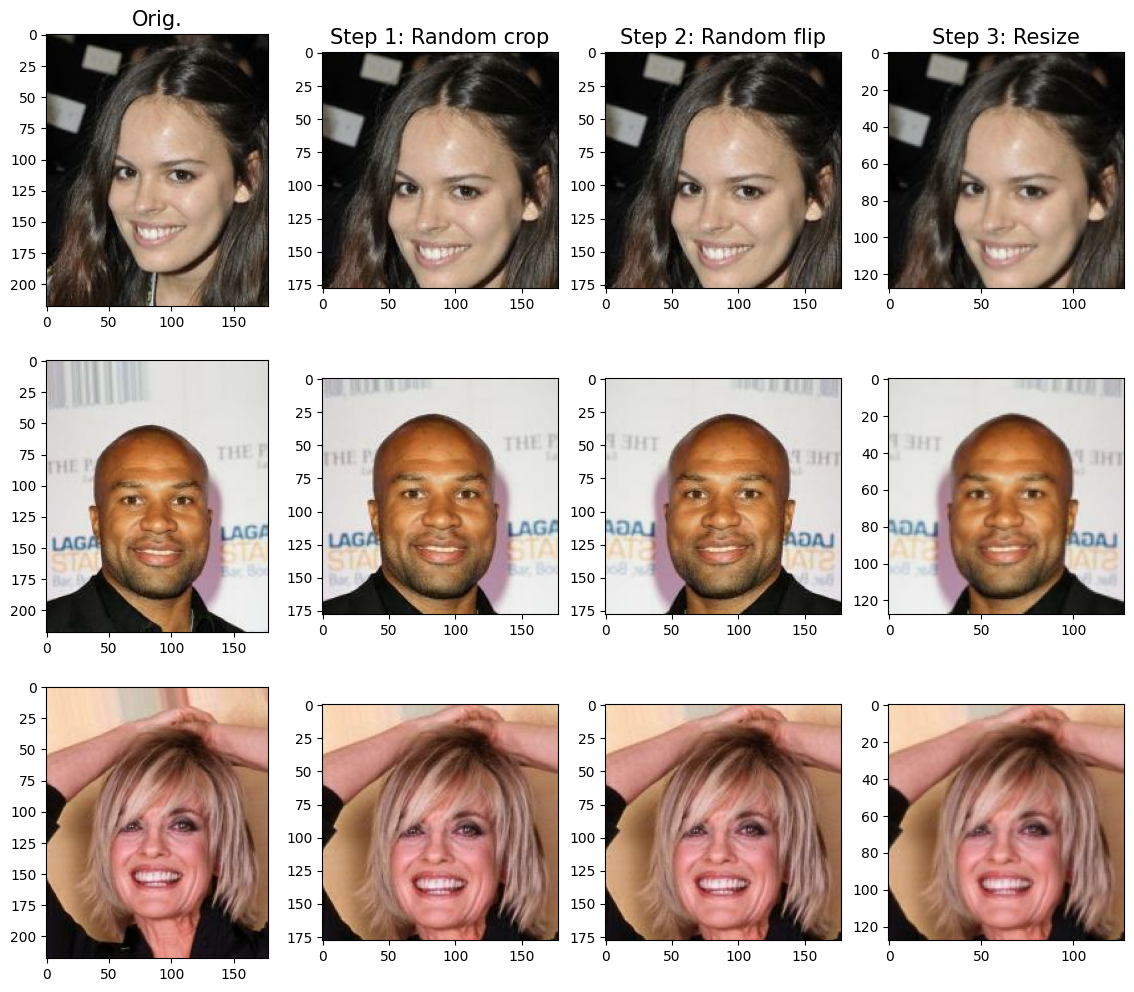

In [6]:
tf.random.set_seed(1)

fig = plt.figure(figsize=(14, 12))

for i,example in enumerate(celeba_train.take(3)):
    image = example['image']

    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(image)
    if i == 0:
        ax.set_title('Orig.', size=15)

    ax = fig.add_subplot(3, 4, i*4+2)
    img_crop = tf.image.random_crop(image, size=(178, 178, 3))
    ax.imshow(img_crop)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)

    ax = fig.add_subplot(3, 4, i*4+3)
    img_flip = tf.image.random_flip_left_right(img_crop)
    ax.imshow(tf.cast(img_flip, tf.uint8))
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    ax = fig.add_subplot(3, 4, i*4+4)
    img_resize = tf.image.resize(img_flip, size=(128, 128))
    ax.imshow(tf.cast(img_resize, tf.uint8))
    if i == 0:
        ax.set_title('Step 3: Resize', size=15)

# plt.savefig('images/15_15.png', dpi=300)
plt.show()

위의 그림은 세 개의 샘플에 랜덤한 변환을 적용한 결과이다.  

랜덤한 변환이므로 코드를 반복 실행할 때마다 조금씩 다른 이미지가 만들어진다.  
사용하기 쉽게 래퍼 함수를 정의하여 모델을 훈련하는 동안 데이터 증식에 이 파이프라인을 사용한다.  

데이터 증식은 훈련 샘플에만 적용하고 검증 샘플과 테스트 샘플에는 적용하지 않는다.

In [7]:
def preprocess(example, size=(64, 64), mode='train'):
    image = example['image']
    label = example['attributes']['Male']
    if mode == 'train':
        image_cropped = tf.image.random_crop(
            image, size=(178, 178, 3))
        image_resized = tf.image.resize(
            image_cropped, size=size)
        image_flip = tf.image.random_flip_left_right(
            image_resized)
        return (image_flip/255.0, tf.cast(label, tf.int32))
    
    else:
        image_cropped = tf.image.crop_to_bounding_box(
            image, offset_height=20, offset_width=0,
            target_height=178, target_width=178)
        image_resized = tf.image.resize(
            image_cropped, size=size)
        return (image_resized/255.0, tf.cast(label, tf.int32))

데이터 증식이 동작하는지 보기 위해 훈련 데이터셋에서 몇 개의 샘플을 추출하고 함수를 다섯 번 반복하여 적용해 본다.

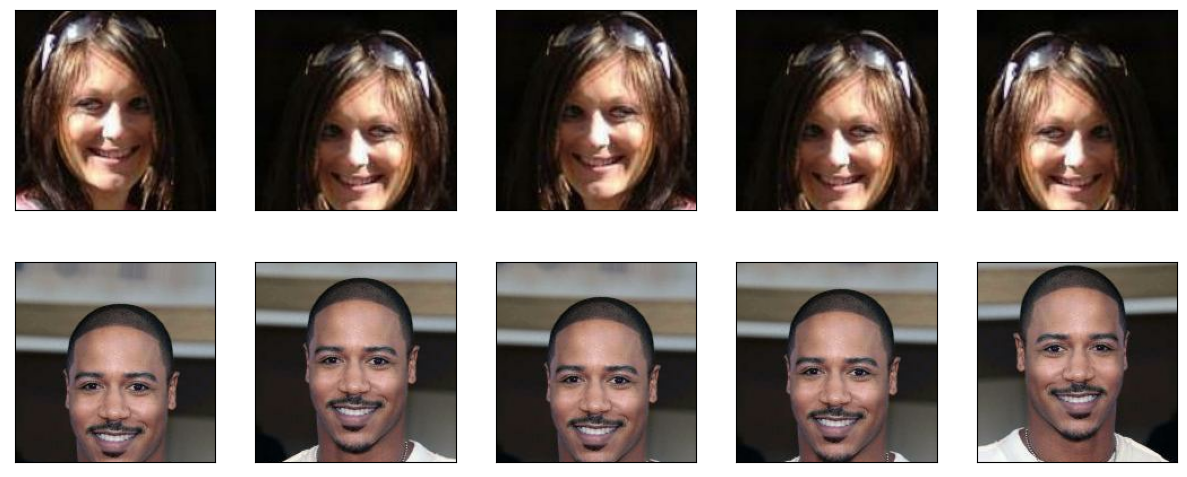

In [8]:
tf.random.set_seed(1)

ds = celeba_train.shuffle(1000, reshuffle_each_iteration=False)
ds = ds.take(2).repeat(5)

ds = ds.map(lambda x:preprocess(x, size=(178, 178), mode='train'))

fig = plt.figure(figsize=(15, 6))
for j,example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j//2+(j%2)*5+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])
    
# plt.savefig('images/15_16.png', dpi=300)
plt.show()

이제 이 전처리 함수를 훈련 데이터셋과 검증 데이터셋에 적용해보자.  
이미지 크기는 (64, 64)를 사용한다. 또한, 훈련 데이터일 때는 `mode='train'`으로 지정하고 검증 데이터일 때는 `mode='eval'`이라고 지정하여 데이터 증식의 랜덤 변환을 훈련 데이터에만 적용한다. 

In [9]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (64, 64)
steps_per_epoch = np.ceil(16000/BATCH_SIZE)
print(steps_per_epoch)

ds_train = celeba_train.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='train'))
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)

ds_valid = celeba_valid.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='eval'))
ds_valid = ds_valid.batch(BATCH_SIZE)

500.0


## CNN 성별 분류기 훈련

이 CNN의 구조는 다음과 같다.  
이 모델은 64X64X3 크기의 입력을 받는다.  

입력 데이터가 네 개의 합성곱 층을 지나 32개, 64개, 128개, 255개의 특성 맵을 만든다.  
3 X 3 크기의 커널을 가진 필터를 사용한다.  
처음 세 개의 합성곱 층 다음에는 최대 풀링 $P_{2 \times 2}$가 뒤따른다.  
두 개의 드롭아웃 층이 규제를 위해 포함한다.

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')
])

In [11]:
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 8, 8, 256])

8 X 8 크기의 특성 맵(또는 채널) 256개가 출력된다.  
이제 하나의 유닛을 가진 출력층을 만들기 위해 완전 연결 층을 추가할 수 있다. 이 특성 맵을 펼치면 완전 연결 층에 주입되는 입력 유닛의개수는 8X8X256=16,384가 된다. 또는 **전역 평균 풀링**(global average-pooling)이라는 새로운 층을 추가할 수 있다.  
이 층은 각 특성 맵의 평균을 독립적으로 계산하기 때문에 은닉 유닛이 256개로 줄어든다. 그다음 완전 연결 층을 추가할 수 있다. 

In [12]:
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 256])

마지막으로 출력 유닛이 한 개인 완전 연결층을 추가한다. 이 경우에는 활성화 함수를 `'sigmoid'`로 지정하거나 모델이 로짓 값을 출력하도록 `activation=None`으로 지정할 수 있다. 

In [14]:
model.add(tf.keras.layers.Dense(1, activation=None))

tf.random.set_seed(1)

model.build(input_shape=(None, 64, 64, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

다음은 모델을 컴파일하는 단계이다. 이때 사용할 손실 함수를 지정해야 한다. 하나의 출력 유닛을 가진 이진 분류이므로 `BinaryCrossentropy`를 사용해야 한다. 또한, 마지막 층에 (`activation=None`으로) 시그모이드 활성화를 적용하지 않았기 때문에 이 모델의 출력은 확률이 아니라 로짓이다. 따라서 `BinaryCrossentropy` 클래스에 `from_logits=True`를 지정하면 손실 함수가 내부적으로 시그모이드 함수를 적용한다. 

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=20,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/20


2022-11-24 14:46:23.651604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


499/500 [============================>.] - ETA: 0s - loss: 0.6506 - accuracy: 0.6017

2022-11-24 14:46:37.677865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 15s 25ms/step - loss: 0.6503 - accuracy: 0.6020 - val_loss: 0.5728 - val_accuracy: 0.6510
Epoch 2/20
500/500 [==============================] - 13s 25ms/step - loss: 0.5440 - accuracy: 0.7074 - val_loss: 0.4982 - val_accuracy: 0.7070
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 0.4848 - accuracy: 0.7491 - val_loss: 0.4169 - val_accuracy: 0.8180
Epoch 4/20
500/500 [==============================] - 12s 25ms/step - loss: 0.4323 - accuracy: 0.7853 - val_loss: 0.3701 - val_accuracy: 0.8110
Epoch 5/20
500/500 [==============================] - 12s 25ms/step - loss: 0.3768 - accuracy: 0.8216 - val_loss: 0.3301 - val_accuracy: 0.8000
Epoch 6/20
500/500 [==============================] - 13s 25ms/step - loss: 0.3124 - accuracy: 0.8541 - val_loss: 0.2179 - val_accuracy: 0.9100
Epoch 7/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2714 - accuracy: 0.8770 - val_loss: 0.1891 - val_accuracy: 0.9170
Epo

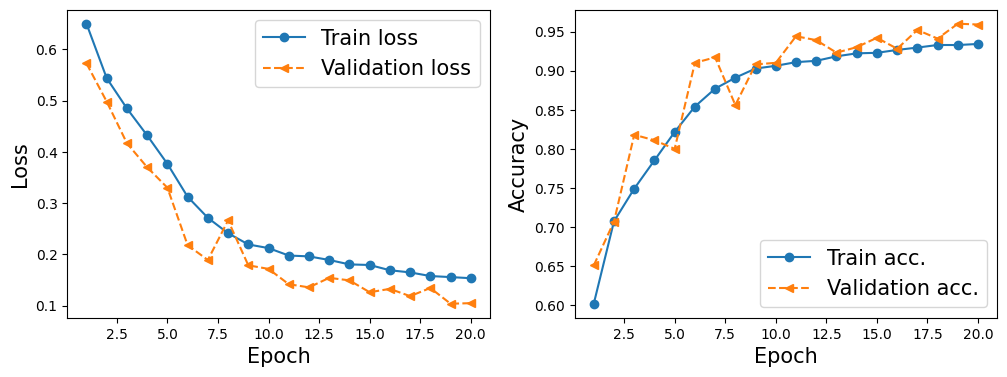

In [16]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

# plt.savefig('images/15_18.png', dpi=300)
plt.show()

학습 곡선에서 볼 수 있듯이 훈련과 검증 손실이 평탄화 영역으로 수렴하지 않는다. 이를 보면 더 많은 에포크에서 훈련을 계속할 수 있다.  
다음과 같이 `fit()` 메서드로 열 번의 에포크를 이어서 훈련할 수 있다. 

In [17]:
history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=30, initial_epoch=20,
                    steps_per_epoch=steps_per_epoch)

Epoch 21/30
500/500 [==============================] - 13s 26ms/step - loss: 0.1482 - accuracy: 0.9369 - val_loss: 0.1011 - val_accuracy: 0.9560
Epoch 22/30
500/500 [==============================] - 13s 25ms/step - loss: 0.1468 - accuracy: 0.9394 - val_loss: 0.1213 - val_accuracy: 0.9370
Epoch 23/30
500/500 [==============================] - 13s 26ms/step - loss: 0.1413 - accuracy: 0.9397 - val_loss: 0.0915 - val_accuracy: 0.9640
Epoch 24/30
500/500 [==============================] - 13s 26ms/step - loss: 0.1454 - accuracy: 0.9364 - val_loss: 0.1173 - val_accuracy: 0.9420
Epoch 25/30
500/500 [==============================] - 14s 28ms/step - loss: 0.1386 - accuracy: 0.9411 - val_loss: 0.1107 - val_accuracy: 0.9570
Epoch 26/30
500/500 [==============================] - 14s 29ms/step - loss: 0.1338 - accuracy: 0.9416 - val_loss: 0.1082 - val_accuracy: 0.9550
Epoch 27/30
500/500 [==============================] - 14s 28ms/step - loss: 0.1388 - accuracy: 0.9396 - val_loss: 0.0964 - val_ac

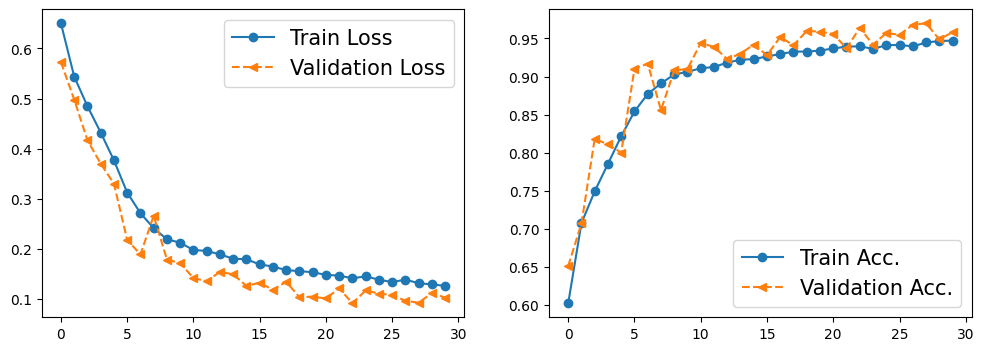

In [18]:
hist2 = history.history
x_arr = np.arange(len(hist['loss'] + hist2['loss']))

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss']+hist2['loss'], '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss']+hist2['val_loss'], '--<', label='Validation Loss')
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy']+hist2['accuracy'], '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_accuracy']+hist2['val_accuracy'], '--<', label='Validation Acc.')
ax.legend(fontsize=15)
plt.show()

In [19]:
ds_test = celeba_test.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='eval')).batch(32)

test_results = model.evaluate(ds_test)
print('테스트 정확도: {:.2f}%'.format(test_results[1]*100))

624/624 [==============================] - 6s 10ms/step - loss: 0.1114 - accuracy: 0.9541
테스트 정확도: 95.41%


마지막으로 `model.predict()`를 사용하여 테스트 샘플의 예측 결과를 얻을 수 있다. 하지만 이 모델은 확률이 아니라 로짓을 출력한다. 하나의 출력 유닛을 가진 이 이진 분류 문제에서 클래스 소속 확률을 얻고 싶다면 `tf.sigmoid` 함수를 사용하여 클래스 1의 확률을 계산할 수 있다.(다중 분류일 경우 `tf.math.softmax`를 사용)  
다음 코드에서 전처리된 테스트 데이터셋(ds_test)에서 추출한 열 개로 `model.predict()`를 호출하여 로짓 값을 얻는다.   

먼저 `ds_test` 데이터셋에서 열 개의 샘플을 추출하기 전에 `unbatch()` 메서드를 적용한다. 그렇지 않으면 `take()` 메서드는 열 개의 샘플이 아니라 크기가 32인 열 개의 배치를 반환한다.

2022-11-24 15:01:29.568750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


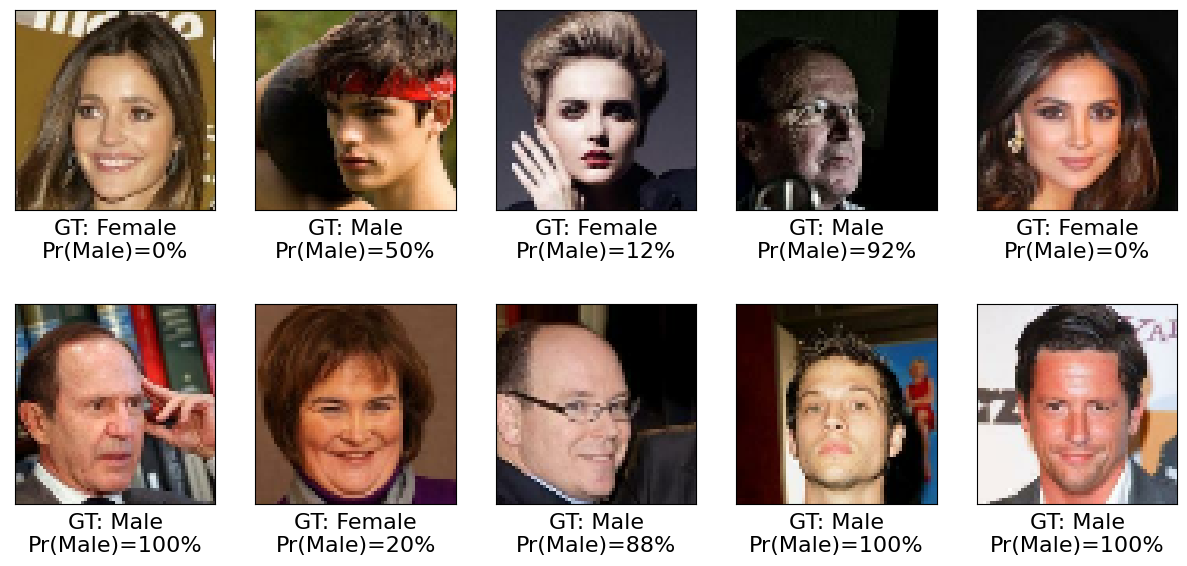

In [20]:
ds = ds_test.unbatch().take(10)

pred_logits = model.predict(ds.batch(10))
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

fig = plt.figure(figsize=(15, 7))
for j,example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    if example[1].numpy() == 1:
        label='Male'
    else:
        label = 'Female'
    ax.text(
        0.5, -0.15, 
        'GT: {:s}\nPr(Male)={:.0f}%'.format(label, probas[j]), 
        size=16, 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
# plt.savefig('images/15_19.png', dpi=300)
plt.show()

In [21]:
model.save('models/celeba-cnn.h5')

추가적인 연습을 위해 여기서 사용한 작은 데이터셋 말고 전체 훈련 데이터셋으로 모델을 훈련해보자.  
CNN 구조도 바꾸어 보자. 예를 들어 드롭아웃 확률과 합성곱 층의 필터 개수를 바꿀 수 있다. 전역 평균 풀링을 밀집 층으로 바꿀 수도 있다.